In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M:%S"))

Summary run: Mon, 19 Apr 2021 14:40:22


In [3]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [4]:
pd.options.display.float_format = '{:0,.0f}'.format

In [5]:
# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'

In [6]:
tod_dict = {
    '5to6': 'AM',
    '6to7': 'AM',
    '7to8': 'AM',
    '8to9': 'AM',
    '9to10': 'Mid-Day',
    '10to14': 'Mid-Day',
    '14to15': 'Mid-Day',
    '15to16': 'PM',
    '16to17': 'PM',
    '17to18': 'PM',
    '18to20': 'Evening',
    '20to5': 'Night'
}

In [7]:
# Load Network Summary sheet from network_summary_detailed
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','VMT by FC')

## Vehicle Miles Traveled (VMT)

In [8]:
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['VMT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VMT']]

# Save total VMT for later use
total_vmt = df_tod.loc['Total'].values[0]

df_fac = pd.DataFrame(df.sum()[['arterial','highway','connector']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VMT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,VMT
Facility Type,
arterial,"38,143,436"
highway,"42,300,987"
connector,"5,438,953"
Total,"85,883,376"


,VMT
period,
am,"20,119,155"
ev,"10,923,280"
md,"28,389,973"
ni,"6,180,833"
pm,"20,270,136"
Total,"85,883,376"


## Vehicle Hours Traveled (VHT)

In [9]:
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','VHT by FC')
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['VHT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VHT']]

df_fac = pd.DataFrame(df.sum()[['arterial','highway','connector']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VHT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,VHT
Facility Type,
arterial,"1,332,810"
highway,"1,015,845"
connector,"348,015"
Total,"2,696,669"


,VHT
period,
am,"649,375"
ev,"363,641"
md,"828,056"
ni,"160,840"
pm,"694,758"
Total,"2,696,669"


## Delay

In [10]:
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','delay by FC')
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['Delay'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['Delay']]

df_fac = pd.DataFrame(df.sum()[['arterial','highway']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'Delay']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,Delay
Facility Type,
arterial,"152,359"
highway,"216,958"
Total,"369,317"


,Delay
period,
am,"122,529"
ev,"51,287"
md,"57,980"
ni,0
pm,"137,520"
Total,"369,317"


## VMT per Person

In [11]:
# Load Daysim results
trip = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_trip.tsv', sep='\t')
person = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_person.tsv', sep='\t')

In [12]:
# Load survey results
surveyh5 = h5py.File(os.path.join(relative_path,r'../inputs/base_year/observed/survey.h5'), 'r')

In [13]:
survey_trip = pd.DataFrame()
survey_person = pd.DataFrame()
for col in surveyh5['Trip'].keys():
    survey_trip[col] = surveyh5['Trip'][col][:]
    
for col in surveyh5['Person'].keys():
    survey_person[col] = surveyh5['Person'][col][:]

In [14]:
pd.options.display.float_format = '{:0,.2f}'.format


# This is average trips
# model_value = trip['trexpfac'].sum()/person['psexpfac'].sum()
# survey_value = survey_trip['trexpfac'].sum()/survey_person['psexpfac'].sum()

_df = pd.DataFrame([total_vmt/person['psexpfac'].sum()])
_df.columns = ['Average VMT per Capita']
_df



,Average VMT per Capita
0,21.19


## Trips per Person

In [15]:
model_result = (trip['trexpfac'].sum()*1.0)/person['psexpfac'].sum()
survey_result = (survey_trip['trexpfac'].sum()*1.0)/survey_person['psexpfac'].sum()

_df = pd.DataFrame([model_result,survey_result])
_df.columns = ['Total Trips per Capita']
_df.index = ['Model', 'Survey']
_df

,Total Trips per Capita
Model,4.03
Survey,4.54


## Average Trip Length

In [16]:
model_result = (trip['travdist']*trip['trexpfac']).sum()/trip['trexpfac'].sum()
survey_result = (survey_trip['travdist']*survey_trip['trexpfac']).sum()/survey_trip['trexpfac'].sum()

_df = pd.DataFrame([model_result,survey_result])
_df.columns = ['Average Trip Length']
_df.index = ['Model','Survey']
_df

,Average Trip Length
Model,5.48
Survey,5.74


## Transit Boardings

In [17]:
df = pd.read_csv(os.path.join(relative_path,'transit','daily_boardings_by_agency.csv'),index_col=0)
df.loc['Region Total','boardings'] = df['boardings'].sum()
df

,boardings
agency_name,
King County Metro,"389,485.96"
Sound Transit,"149,206.85"
Pierce Transit,"34,547.71"
Community Transit,"32,790.46"
Kitsap Transit,"17,983.30"
Washington Ferries,"11,613.06"
Everett Transit,"5,260.90"
Region Total,"640,888.24"


## Trip Mode Share

,Model,Survey
mode,,
Walk,12.7%,12.5%
Bike,1.4%,1.3%
SOV,41.4%,40.8%
HOV2,22.8%,22.0%
HOV3+,15.7%,15.8%
Transit,2.9%,4.9%
School Bus,2.0%,2.2%
TNC,1.1%,0.5%


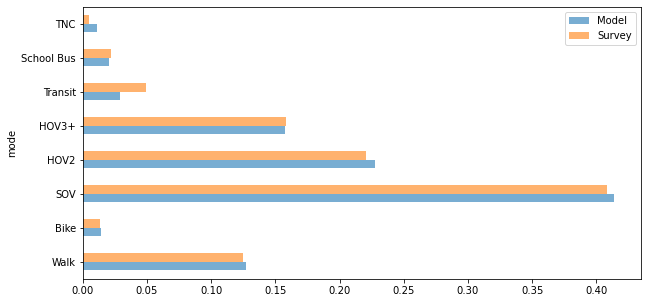

In [18]:
pd.options.display.float_format = '{:,.1%}'.format
model_df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
model_df = model_df.reset_index()
survey_df = survey_trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/survey_trip[['trexpfac']].sum()
survey_df = survey_df.reset_index()
_df = pd.merge(model_df, survey_df, on='mode', how='left')
_df.columns = ['mode','Model', 'Survey']
# _df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
# _df = _df.reset_index()
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
_df.replace({'mode':mode_dict}, inplace=True)
_df.index = _df['mode']
_df.drop('mode', axis=1, inplace=True)
dfplot = _df.drop('Other', axis=0)
dfplot.plot(kind='barh', alpha=0.6, figsize=(10,5))
display(dfplot)


# Home-Based Work Trip Mode Share

In [23]:
trip['Trip Type'] = 'Not Home-Based Work'
trip.loc[(((trip['opurp']==0) & (trip['dpurp']==1)) | ((trip['opurp']==1) & (trip['dpurp']==0))),'Trip Type']= 'Home-Based Work'
hbw_trips = trip.loc[trip['Trip Type']=='Home-Based Work']
model_df_hbw = hbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/hbw_trips[['trexpfac']].sum()
model_df_hbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
model_df_hbw.replace({'mode':mode_dict}, inplace=True)
model_df_hbw.columns = ['mode', 'share']
model_df_hbw

# Survey trip
survey_trip = pd.read_csv(os.path.join(relative_path,r'../inputs/base_year/survey/_trip.tsv'), delim_whitespace=True)
survey_trip.loc[(((survey_trip['opurp']==0) & (survey_trip['dpurp']==1)) | ((survey_trip['opurp']==1) & (survey_trip['dpurp']==0))),'Trip Type']= 'Home-Based Work'
survey_hbw_trips = survey_trip.loc[survey_trip['Trip Type']=='Home-Based Work']
survey_df_hbw = survey_hbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/survey_hbw_trips[['trexpfac']].sum()
survey_df_hbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
survey_df_hbw.replace({'mode':mode_dict}, inplace=True)
survey_df_hbw.columns = ['mode', 'share']

model_df_hbw.merge(survey_df_hbw, on='mode', suffixes=['_model','_survey']).reset_index()

,index,mode,share_model,share_survey
0,0,Walk,5.8%,5.3%
1,1,Bike,1.4%,1.3%
2,2,SOV,71.0%,71.2%
3,3,HOV2,10.5%,8.4%
4,4,HOV3+,4.8%,2.6%
5,5,Transit,6.0%,9.6%
6,6,School Bus,0.0%,0.1%
7,7,TNC,0.5%,0.8%


# Other Trip Mode Share (Not Home-Based Work)

In [24]:
nhbw_trips = trip.loc[trip['Trip Type']!='Home-Based Work']
model_df_nhbw = nhbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/nhbw_trips[['trexpfac']].sum()
model_df_nhbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
model_df_nhbw.replace({'mode':mode_dict}, inplace=True)
model_df_nhbw.columns = ['mode', 'share']


# Survey trip
survey_nhbw_trips = survey_trip.loc[trip['Trip Type']!='Home-Based Work']
survey_df_nhbw = survey_nhbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/survey_nhbw_trips[['trexpfac']].sum()
survey_df_nhbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
survey_df_nhbw.replace({'mode':mode_dict}, inplace=True)
survey_df_nhbw.columns = ['mode', 'share']


survey_df_nhbw.merge(model_df_nhbw, on='mode', suffixes=['_model','_survey']).reset_index()

,index,mode,share_model,share_survey
0,0,Walk,11.6%,13.9%
1,1,Bike,0.9%,1.4%
2,2,SOV,42.0%,36.2%
3,3,HOV2,23.4%,24.9%
4,4,HOV3+,16.0%,17.6%
5,5,Transit,3.7%,2.3%
6,6,School Bus,1.2%,2.4%
7,7,TNC,0.3%,1.2%
